# Ridge

Following [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), it performs a regression trying to minimize the sum of squared error (as the linear regression above does) with a penalty on the size of the coefficients. Therefore, it tries to minimize the following quantity
$$ ||y - Xw||^2_2 + \alpha  ||w||^2_2 , $$ 
where $w$ is the coefficient vector and the parameter $\alpha$ controls the amount of regularization (called $L_2$ as it uses the $L_2$ norm of the coefficient vector). The higher this parameter, the lower will be the variance of the model.

It is a very useful regularization in case of multicollinearity in the input data that tipically lead to very large coefficients. The regularization is putting a penalty on larger coefficients, thus reducing the effect of multicollinearity.

On the contrary of the simple linear regression, we have some hyperparameters to play with

In [1]:
import pandas as pd
import numpy as np

import random

import source.hyperplots as hyp
import source.explore as exp
from source.report import plot_predictions, make_results, store_results
from source.utility import cv_score, grid_search
import source.transf_univ as df_p
from source.experiments import make_exp, learning_curve, import_hp, hp_model

from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge, Perceptron

%matplotlib inline
pd.set_option('max_columns', 500)

lab_book = 'data/02_linear_models.csv'  # for storing results

In [2]:
Ridge()

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

* **alpha**: the regularization and most important hyperparameter to tune. It must be positive. When set to 0, we get the simple Linear regression.
* **copy_X**: that does not affect the results of the model but, if False, may lead to overwriting the input data
* **fit_intercept**: whether or not using an intercept term, not relevant for our cases as we, rightfully, always scale and center our data
* **max_iter**: a parameter that control the maximum number of iterations the solver can take to converge. Very rarely it needs to be increased and, if so, we might need to consider a different approach
* **normalize**: whether or not normalizing the data and it is ignored if set to False. If True, it uses the StandardScaler we already have in our pipeline
* **random_state**: relevant only for one of the solver since it is stochastic (the 'sag' solver)
* **solver**: the type of solver. Almost always leaving to `auto` is a good move as it will pick the best one for the data provided. The coiche will influence the speed and the behavior in particular situations.
* **tol**: the precision of the solution

We will play around with some of these hyperparameters to better understand what is their role.

# Noise and correlation

We can now repeat the previous experiments and observe how the algorithm is behaving differently even in the simplest case.

In [3]:
model = Pipeline([('imputer', df_p.df_imputer()), # everything assumes a 2 steps pipeline
                  ('ridge', Ridge())])
params = {'alpha': 1}

kfolds = KFold(10, shuffle=True, random_state=541)

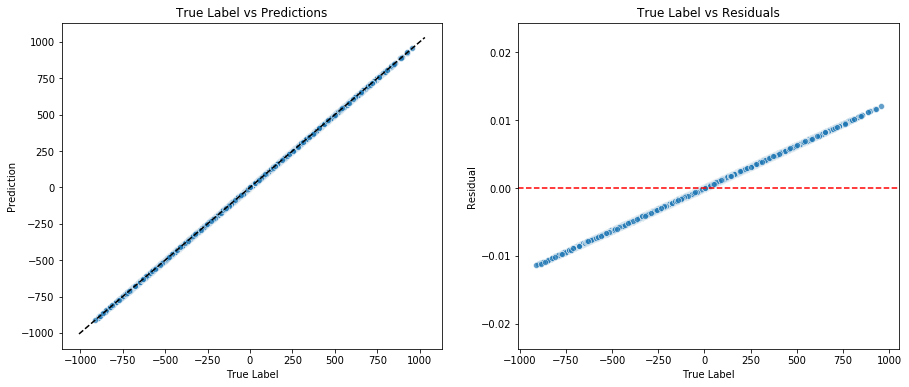

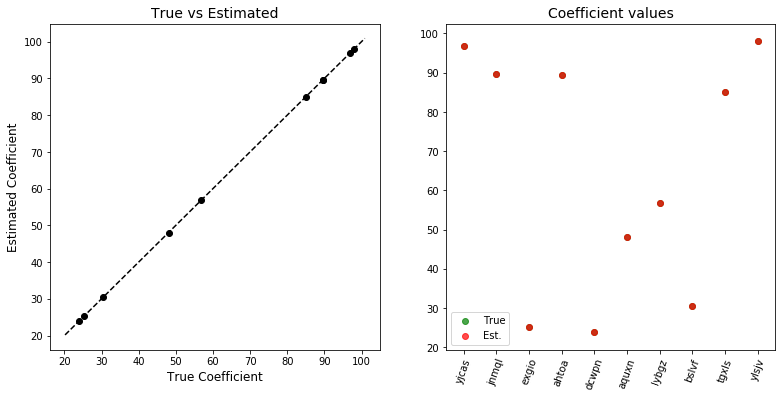

MAE: 		 0.00223
MSE: 		 1e-05
Max Error: 	 0.01208
Expl Variance: 	 1.0


In [26]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_nonoise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='Ridge')

While the coefficients are again estimated perfectly, the residuals show a pattern that suggests that the model is having more and more troubles in predicting larger (in the absolute sense) values of the target variable.

On the other hand, the predictions in presence of noise and/or correlation are nearly identical

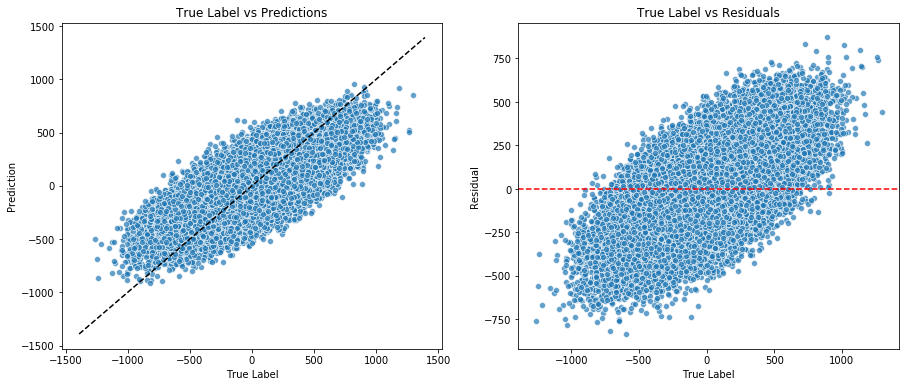

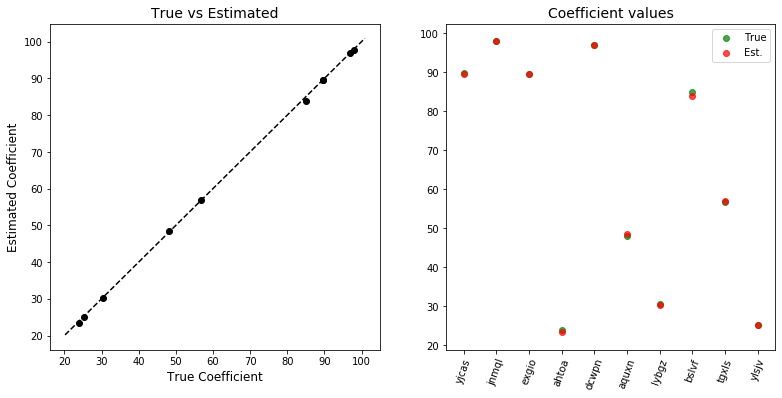

MAE: 		 159.15957
MSE: 		 39903.46366
Max Error: 	 870.78567
Expl Variance: 	 0.55337


In [5]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_noise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='Ridge')

Which is precisely the same result we got without the regularization

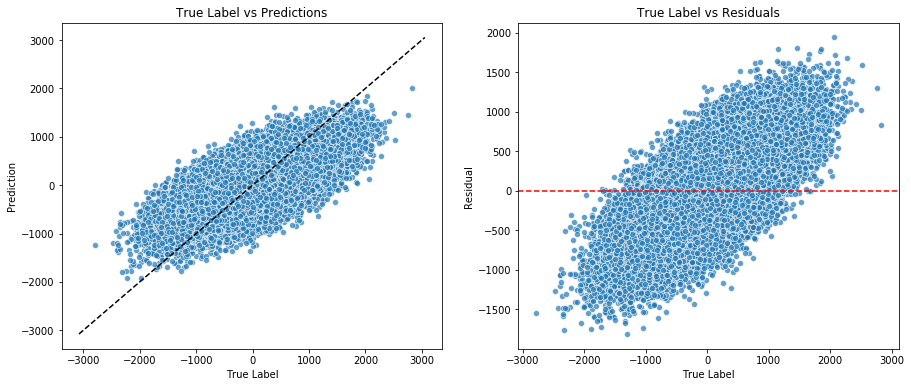

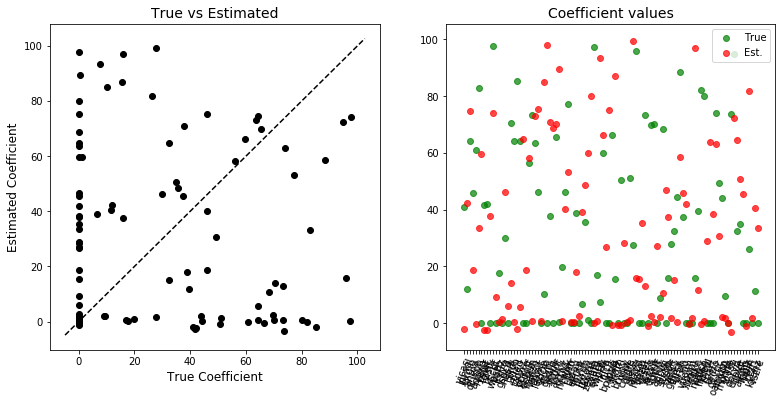

MAE: 		 359.51791
MSE: 		 202633.43736
Max Error: 	 1939.61387
Expl Variance: 	 0.48907


In [6]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/100_feat_65_inf_noise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='Ridge')

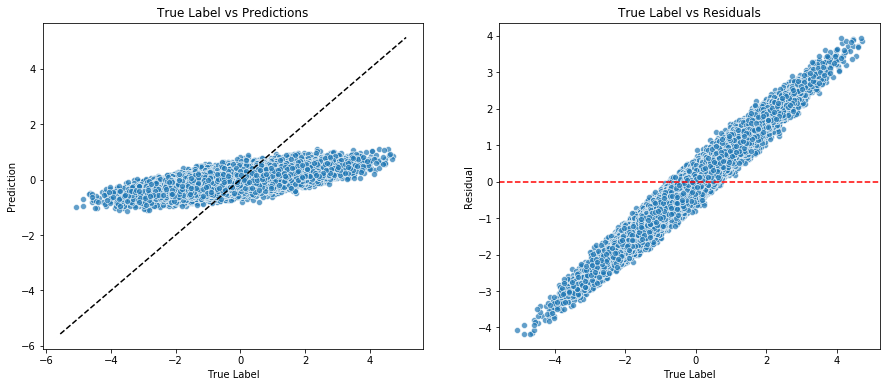

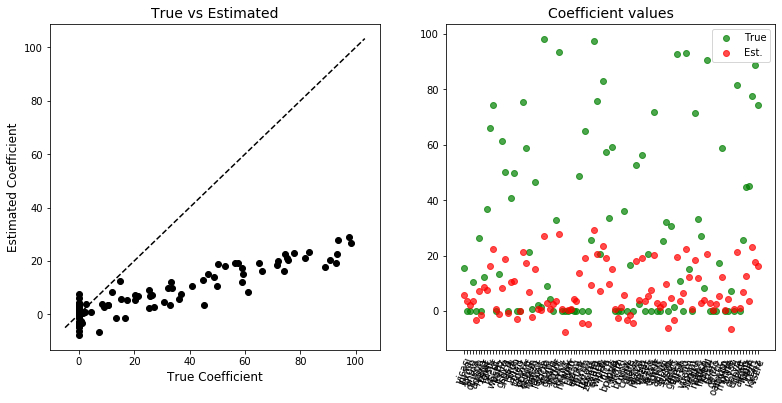

MAE: 		 0.79954
MSE: 		 1.00325
Max Error: 	 4.16769
Expl Variance: 	 0.26507


In [7]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/100_feat_65_inf_noise_rank.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='Ridge')

# Number of instances

The behavior is not changing much when we introduce the regularization. However, the solver is now chosen automatically given the features and this leads to a faster training time. The training time still grows linearly, but with a lower rate of increase.

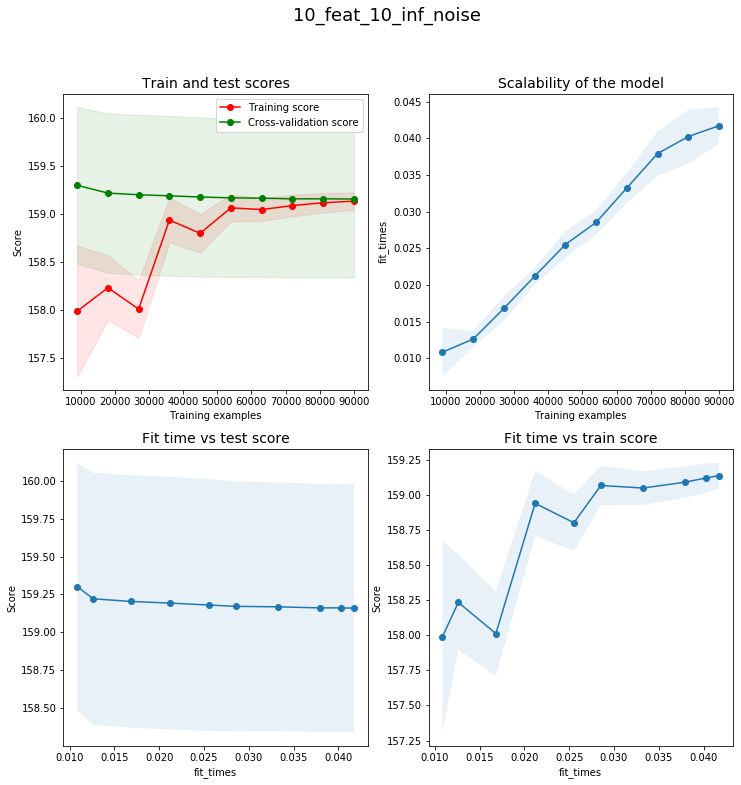

In [8]:
learning_curve(model=model, data_name='data/simulated/10_feat_10_inf_noise.csv', kfolds=kfolds)

For comparison, on the next set of data the fit time was going as high as 3 seconds, while now it is around 0.5 seconds.

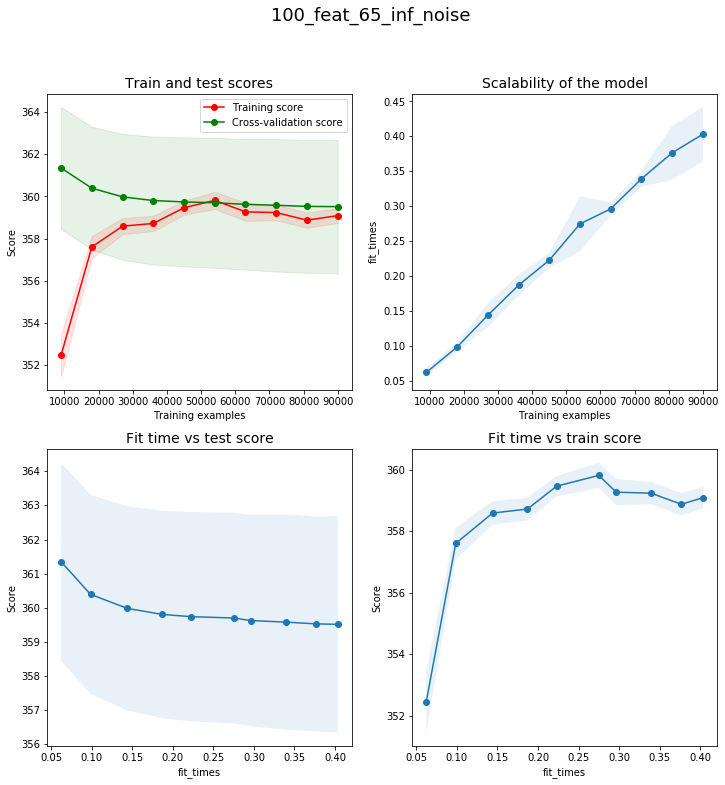

In [9]:
learning_curve(model=model, data_name='data/simulated/100_feat_65_inf_noise.csv', kfolds=kfolds)

It is important to keep in mind that the higher speed has nothing to do with the regularization introduced but rather with **a better implementation of the algorithm**. Therefore, if you ever need a faster version of `LinearRegression`, you could rely on `Ridge(alpha=0)`

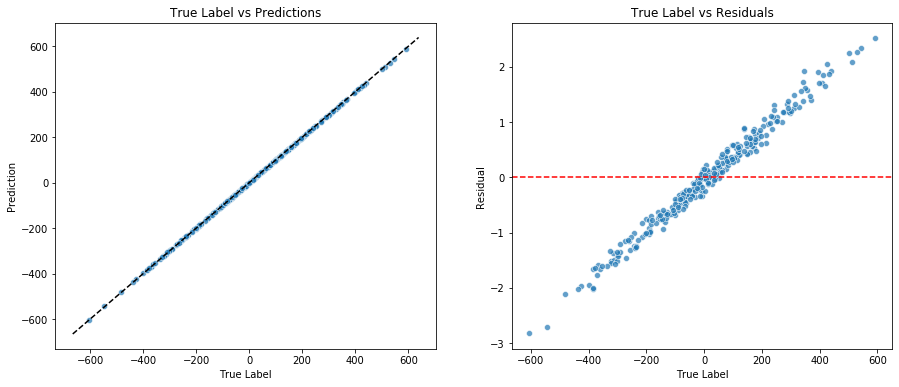

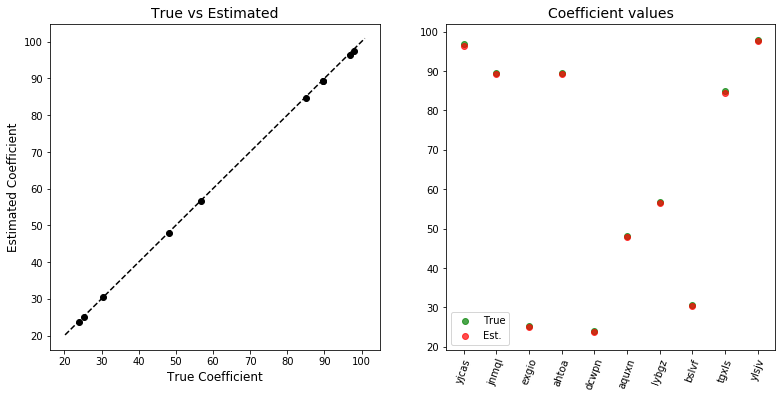

MAE: 		 0.72404
MSE: 		 0.86907
Max Error: 	 2.82383
Expl Variance: 	 0.99998


In [10]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_nonoise.csv', 
         target_name=None, 
         features='all',
         sample=300, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='Ridge')

For the first time we notice that the regularized model is performing better than the simple linear regression in presence of noise when the we have a limited number of instances. The better performance is visible in all the metrics and in the coefficients estimates

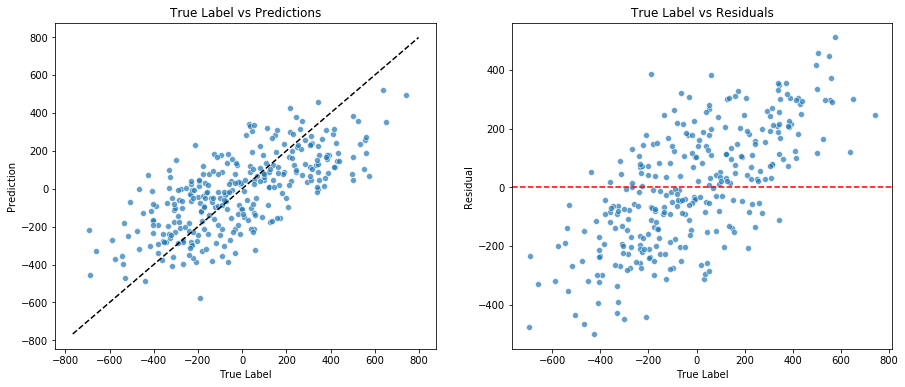

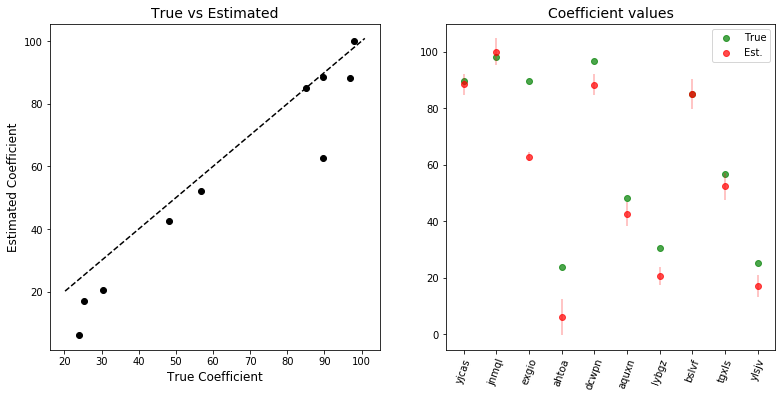

MAE: 		 167.59511
MSE: 		 40935.85581
Max Error: 	 510.34785
Expl Variance: 	 0.48298


In [11]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_noise.csv', 
         target_name=None, 
         features='all',
         sample=300, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='Ridge')

# More complex data

To observe more meaningful patterns, we turn out attention to a dataset with more complex relations

## 100 features

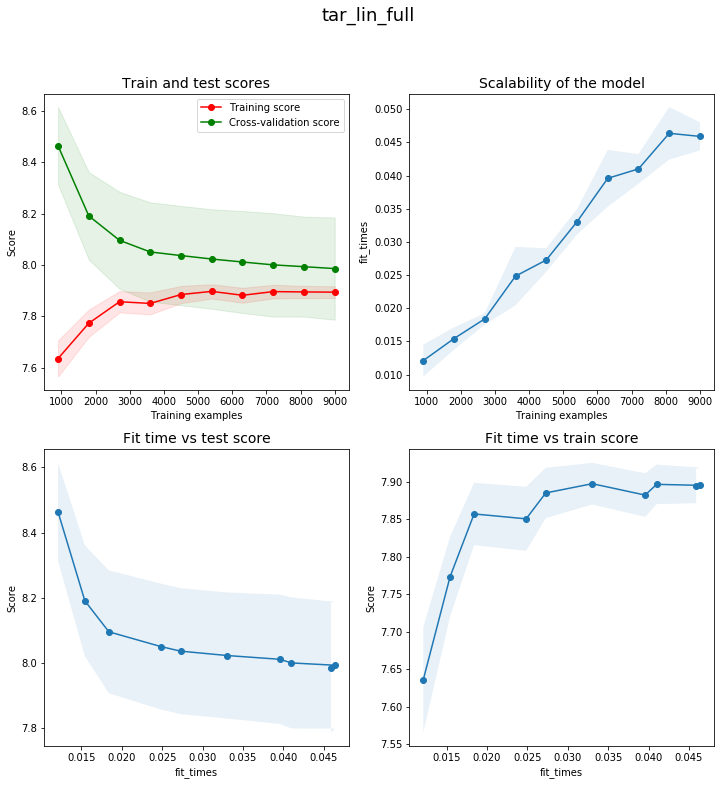

In [12]:
learning_curve(model, target_name='tar_lin_full', features='all', sample=10000, kfolds=kfolds)

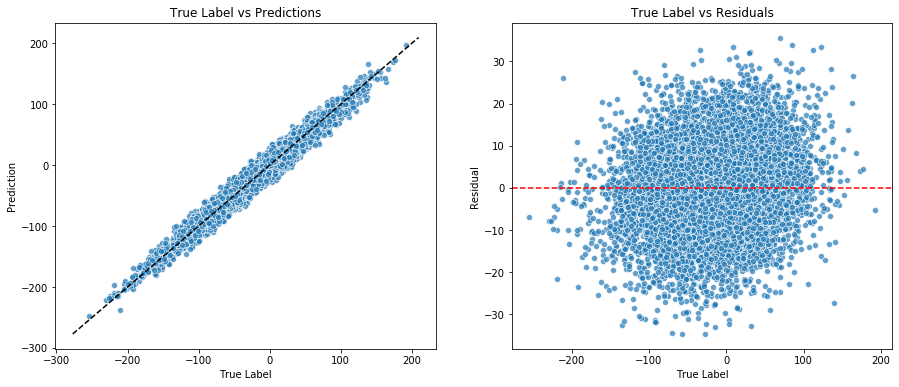

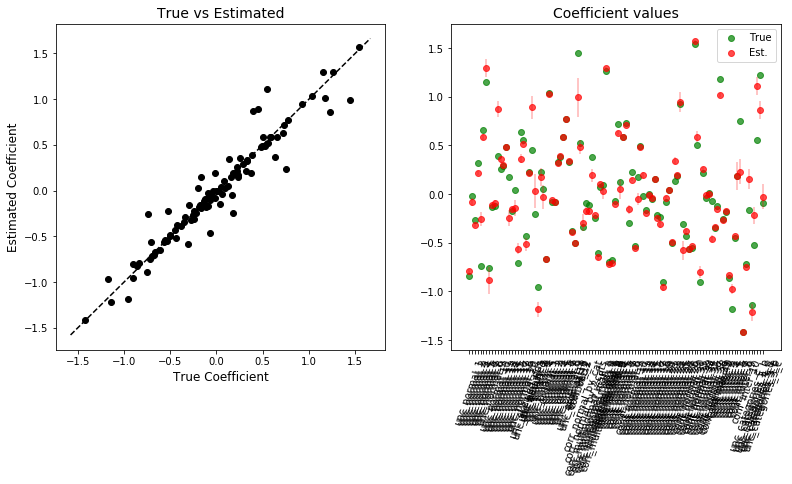

MAE: 		 7.99073
MSE: 		 100.54436
Max Error: 	 35.67643
Expl Variance: 	 0.96867


In [13]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='all',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='Ridge')

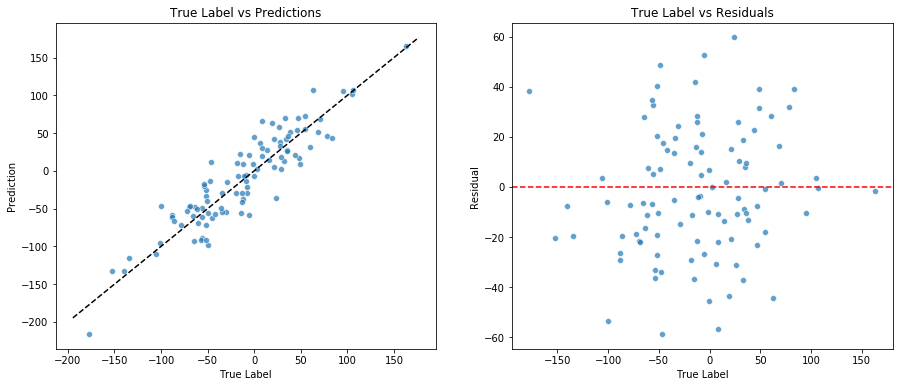

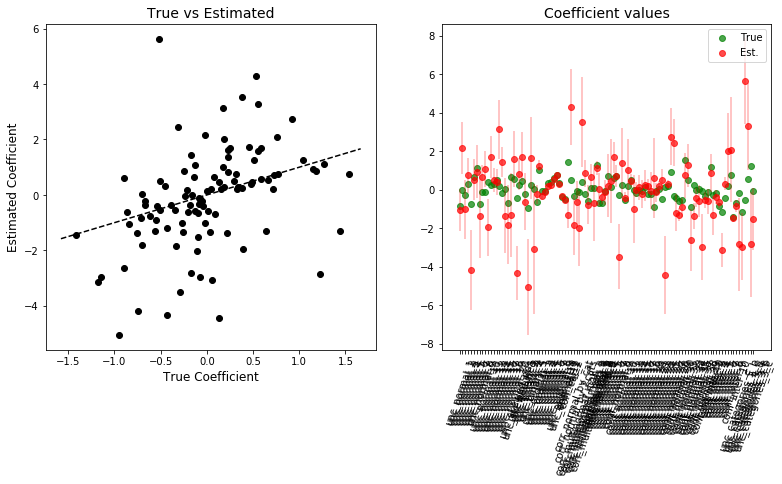

MAE: 		 20.80881
MSE: 		 644.34272
Max Error: 	 59.64066
Expl Variance: 	 0.81495


In [14]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='all',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='Ridge')

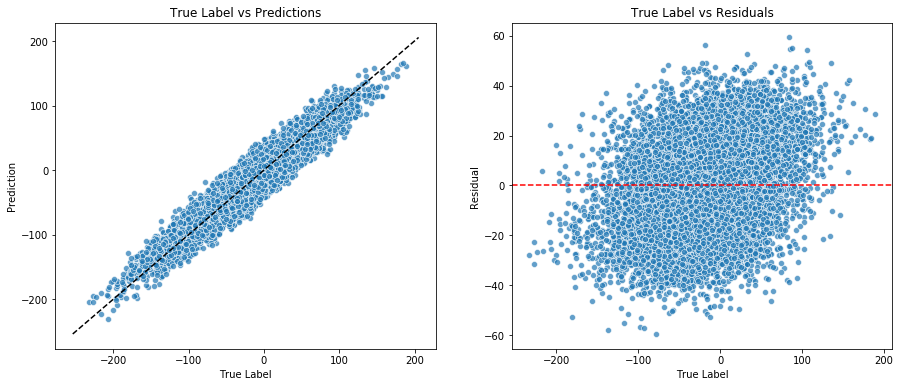

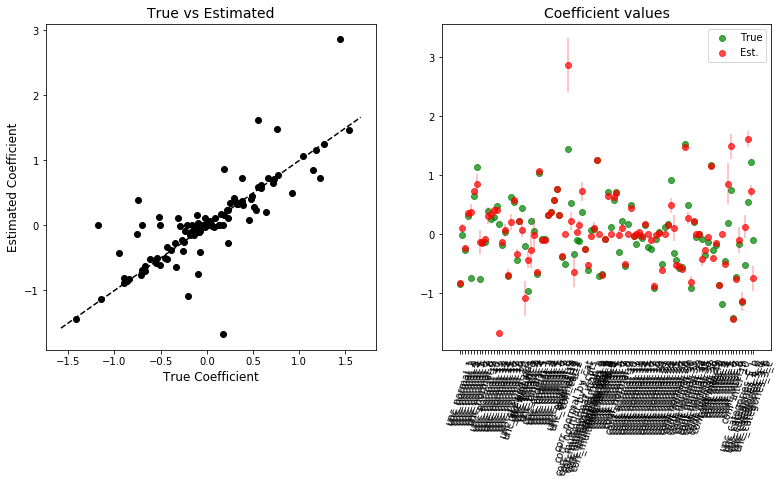

MAE: 		 15.60844
MSE: 		 357.0361
Max Error: 	 59.46725
Expl Variance: 	 0.89384


In [15]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='unobserved',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='Ridge')

## 50 features

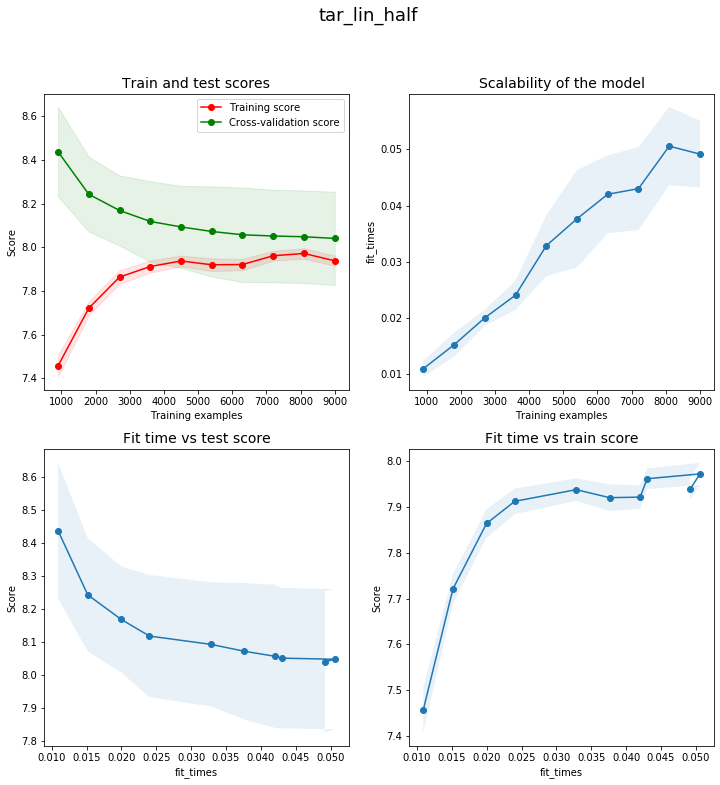

In [16]:
learning_curve(model, target_name='tar_lin_half', features='all', sample=10000, kfolds=kfolds)

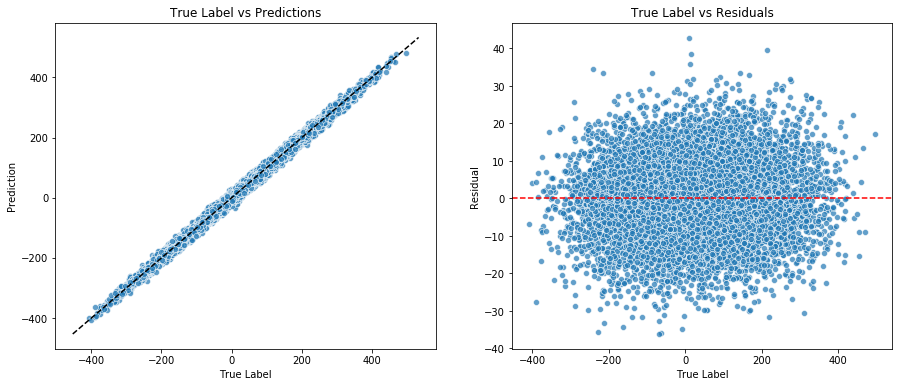

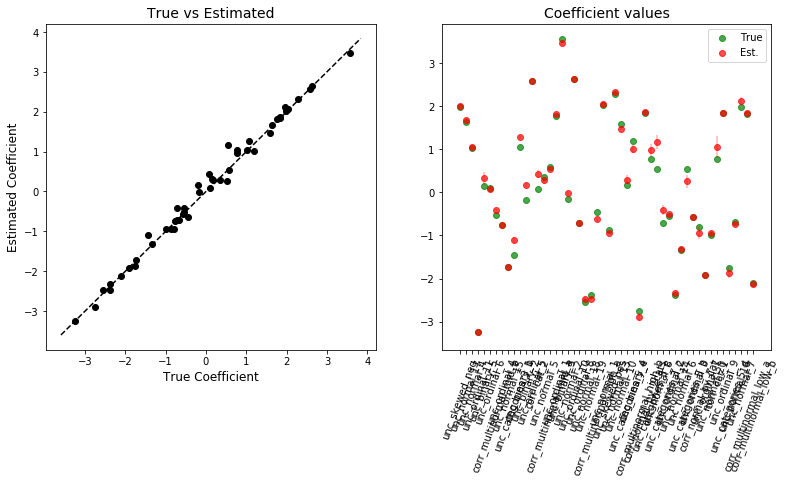

MAE: 		 8.08679
MSE: 		 103.45848
Max Error: 	 42.92324
Expl Variance: 	 0.99532


In [17]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='Ridge')

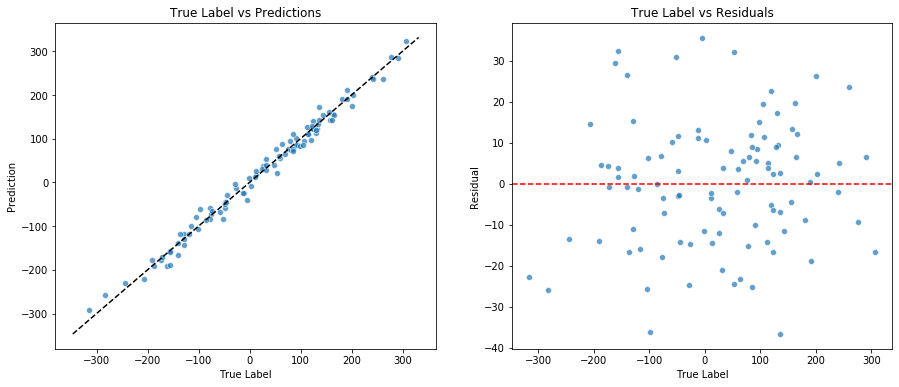

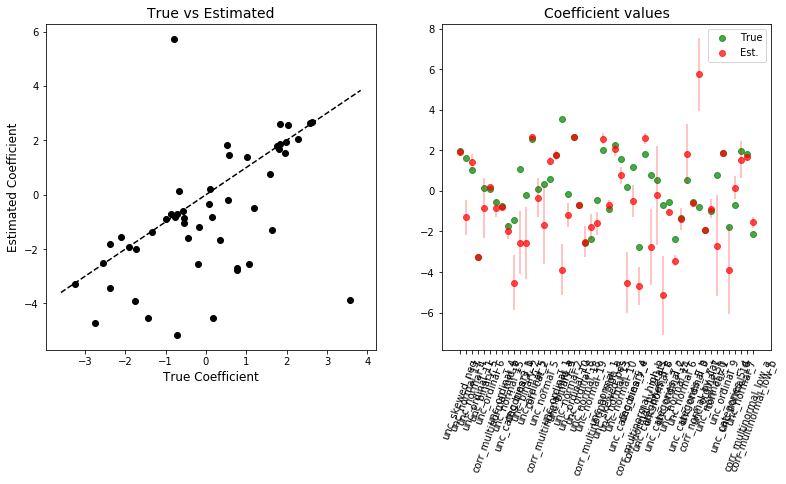

MAE: 		 12.10894
MSE: 		 230.90439
Max Error: 	 36.64108
Expl Variance: 	 0.98713


In [18]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name='Ridge')

## Hyperparameters

All the above experiments were performed using the default hyperparameters, which generally gives a good indication of the model performance to compare results. However, this time we can control more the behavior of the model. This section will do just that.

First, we need to generate the results for different model configurations. We do so by using the custom grid search function imported from the utility module.

We will explore configurations that differ per regularization, precision, and solver type. Due to the need of seeing some pattern, we will use a dataset without noise in order to have errors at an order of magnitude that let us see the variation when the hyperparameter varies. Later, using more complex dataset, we will see more interesting patterns.

Moreover, we noticed already that with enough observations the regularization is not changing the result significantly. We will thus focus on a limited sample size, in the hope this will be enough to draw some conclusions

In [28]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('ridge', Ridge(random_state=325))])

param_grid = {'ridge__alpha': list(np.arange(0, 11, 1)), 
              'ridge__tol': np.arange(0.001, 0.01, 0.001), 
              'ridge__solver': ['svd', 'sparse_cg', 'lsqr', 'saga']}

df = pd.read_csv('data/simulated/100_feat_65_inf_nonoise.csv').sample(500)

target = df['target']

df_train = df.drop('target', axis=1)

res, bp, _ = grid_search(df_train, target, model, param_grid, 'neg_mean_squared_error', kfolds)

print(bp)
res.head()

{'ridge__alpha': 0, 'ridge__solver': 'svd', 'ridge__tol': 0.001}


,param_ridge__alpha,param_ridge__solver,param_ridge__tol,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,0,svd,0.001,-1.146677e-24,3.628974e-25,-1.157465e-24,2.887642e-25,0.007997,0.000092,0.001693,0.000091
1,0,svd,0.002,-1.146677e-24,3.628974e-25,-1.157465e-24,2.887642e-25,0.007711,0.000176,0.001644,0.000068
2,0,svd,0.003,-1.146677e-24,3.628974e-25,-1.157465e-24,2.887642e-25,0.007763,0.000130,0.001643,0.000044
3,0,svd,0.004,-1.146677e-24,3.628974e-25,-1.157465e-24,2.887642e-25,0.007652,0.000164,0.001603,0.000037
4,0,svd,0.005,-1.146677e-24,3.628974e-25,-1.157465e-24,2.887642e-25,0.007760,0.000178,0.001641,0.000049


First, we see how the choice of the solver is influencing the training time, with `lsqr` and `sparse_cg` being the fastest. On the other hand, different solvers seem to get different scores but it is worth noticing that, by increasing the regularization, this difference becomes less and less relevant.

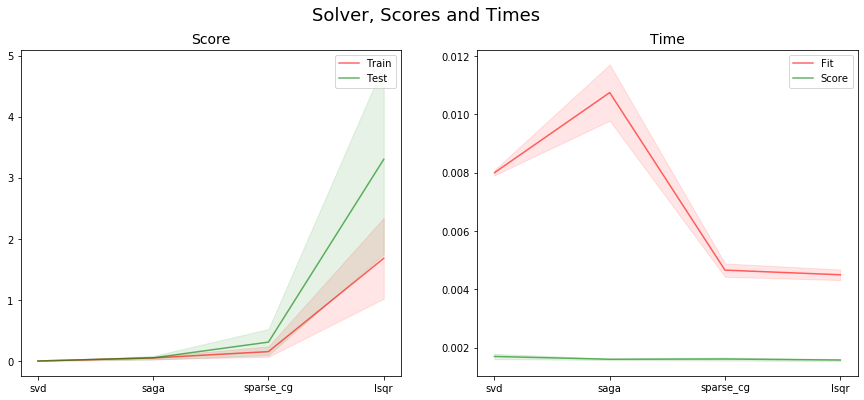

In [29]:
hyp.plot_hyperparameter(res[(res.param_ridge__alpha == 0) & (res.param_ridge__tol==0.001)], 'param_ridge__solver', 'Solver')

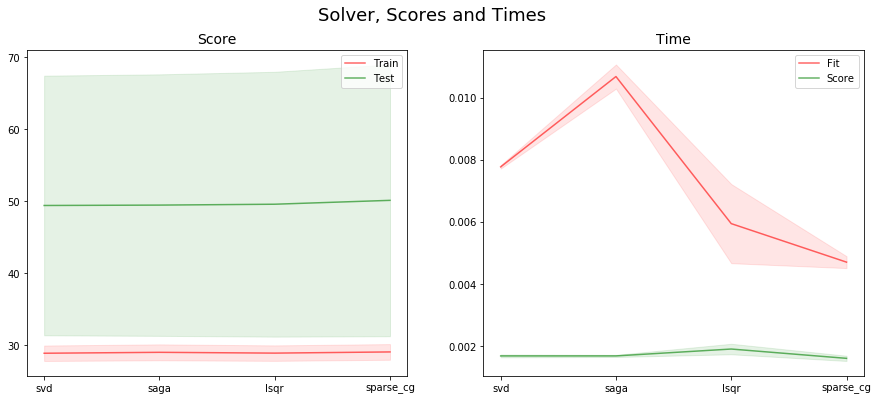

In [30]:
hyp.plot_hyperparameter(res[(res.param_ridge__alpha == 5) & (res.param_ridge__tol==0.001)], 'param_ridge__solver', 'Solver')

This is an artifact of the role of alpha in the model performance, which in this case (a purely linear regression) is getting worse and worse when alpha gets bigger. At the same time, we also notice that this choice does not influence the training time.

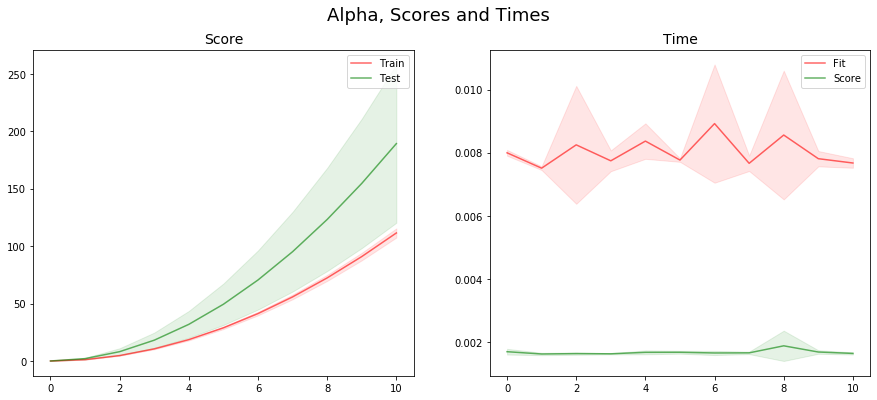

In [31]:
hyp.plot_hyperparameter(res[(res.param_ridge__solver=='svd') & (res.param_ridge__tol==0.001)], 'param_ridge__alpha', 'Alpha')

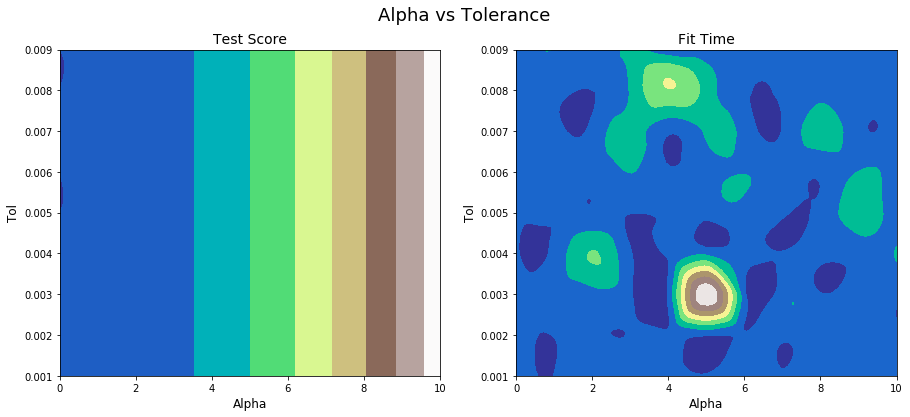

In [34]:
hyp.plot_two_hyperparms(res[(res.param_ridge__solver=='svd')], 'param_ridge__alpha', 'param_ridge__tol', 'Alpha vs Tolerance')

# Real application - HousePrice

In [10]:
model = ('ridge', Ridge())
params = {'alpa':1}

In [22]:
param_grid = {'ridge__alpha': np.arange(1, 42, 5),  
              'ridge__tol': np.arange(0.001, 0.01, 0.001),
              'ridge__solver': ['svd', 'sparse_cg', 'lsqr', 'saga']}

df = import_hp()

target = df['target']

df_train = df.drop('target', axis=1)

modelhp = hp_model(model)

res, bp, _ = grid_search(df_train, target, modelhp, param_grid, 'neg_mean_squared_error', kfolds)

print(bp)
res.head()

/home/lucabasa/Git/ML-algorithms-and-experiments/MLalgo/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


{'ridge__alpha': 11, 'ridge__solver': 'svd', 'ridge__tol': 0.001}


,param_ridge__alpha,param_ridge__solver,param_ridge__tol,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,11,svd,0.009,-0.011641,0.000408,-0.013425,0.003886,0.185097,0.003735,0.103010,0.004414
1,11,svd,0.008,-0.011641,0.000408,-0.013425,0.003886,0.188138,0.006326,0.104210,0.005246
2,11,svd,0.004,-0.011641,0.000408,-0.013425,0.003886,0.185415,0.004195,0.102806,0.002819
3,11,svd,0.003,-0.011641,0.000408,-0.013425,0.003886,0.185208,0.003464,0.105950,0.005036
4,11,svd,0.002,-0.011641,0.000408,-0.013425,0.003886,0.187747,0.005040,0.103511,0.002354


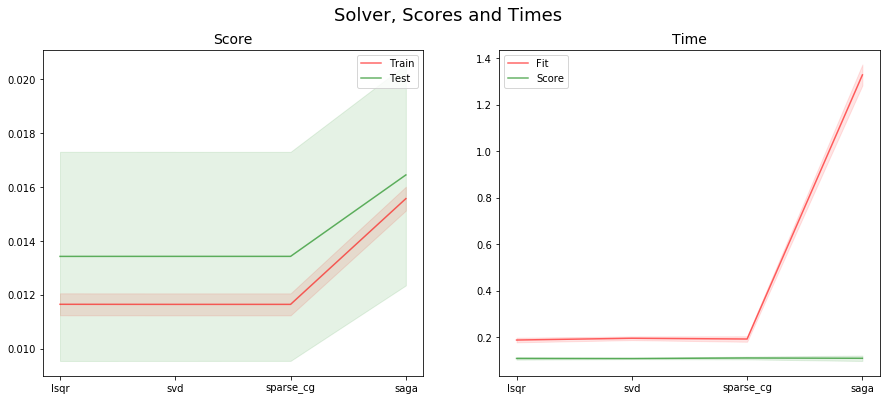

In [15]:
hyp.plot_hyperparameter(res[(res.param_ridge__alpha == 11) & (res.param_ridge__tol==0.00001)], 'param_ridge__solver', 'Solver')

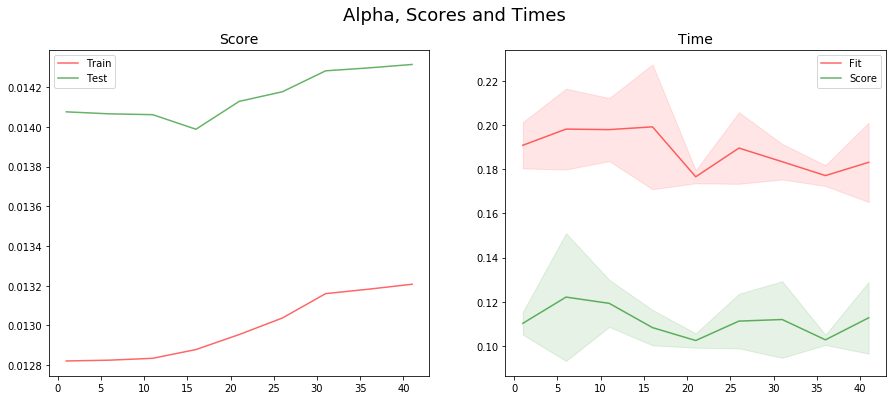

In [25]:
hyp.plot_hyperparameter(res[(res.param_ridge__solver=='lsqr') & (res.param_ridge__tol==0.001)], 
                        'param_ridge__alpha', 'Alpha', uncertainty=False)

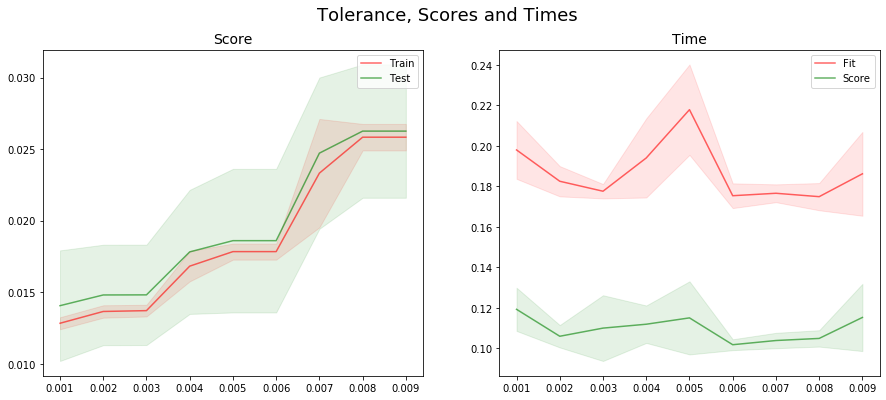

In [27]:
hyp.plot_hyperparameter(res[(res.param_ridge__solver=='lsqr') & (res.param_ridge__alpha==11)], 
                        'param_ridge__tol', 'Tolerance', uncertainty=True)

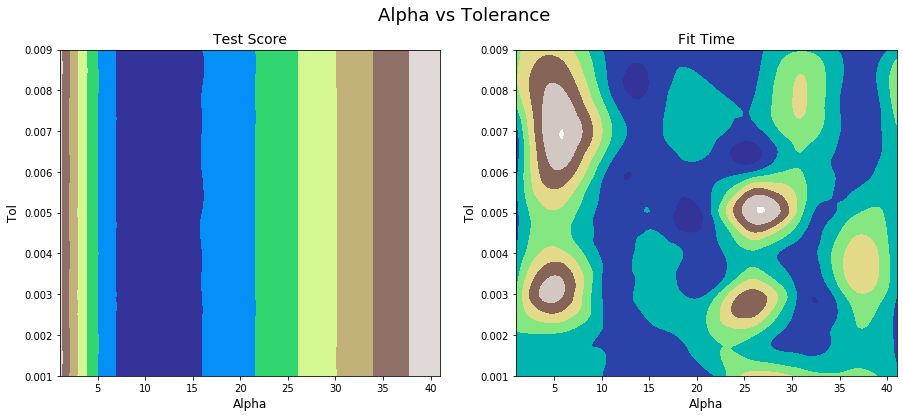

In [26]:
hyp.plot_two_hyperparms(res[(res.param_ridge__solver=='svd')], 'param_ridge__alpha', 'param_ridge__tol', 'Alpha vs Tolerance')

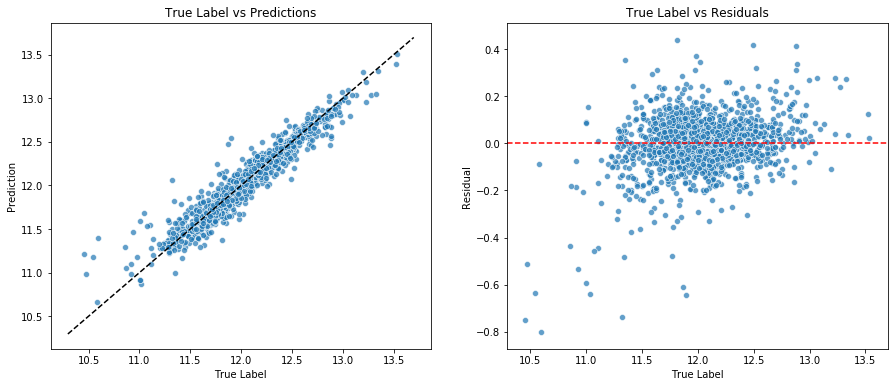

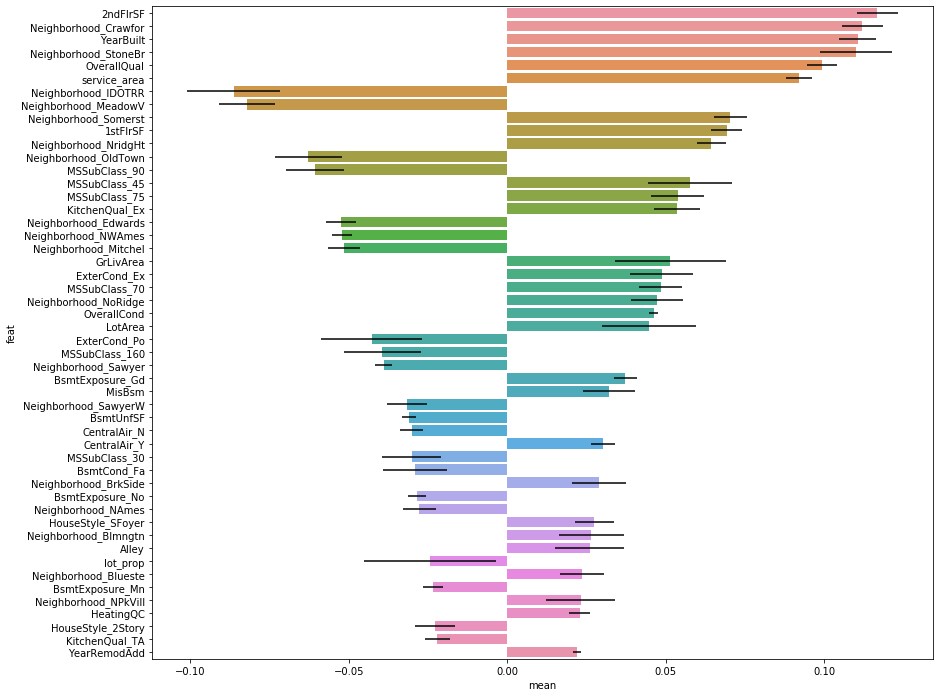

MAE: 		 0.08009
MSE: 		 0.01365
Max Error: 	 0.79924
Expl Variance: 	 0.91452


In [4]:
model = ('ridge', Ridge())
params = {'alpa':1}

make_exp(model=model, kfolds=kfolds, 
         hp=True,
         store=True, store_name=lab_book, 
         parameters=params, model_name='Ridge')

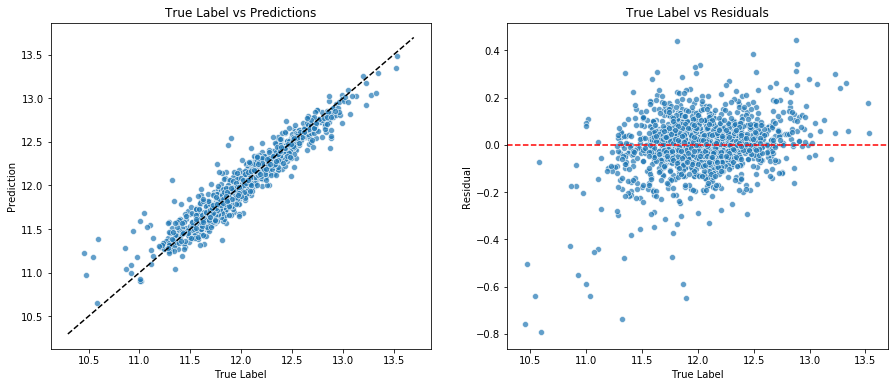

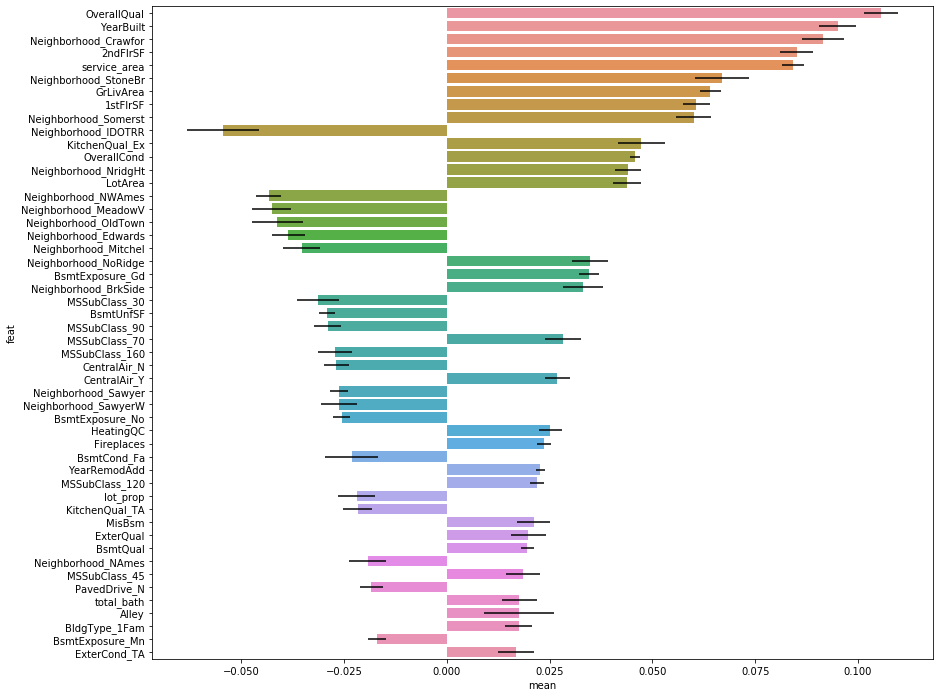

MAE: 		 0.07935
MSE: 		 0.01342
Max Error: 	 0.79042
Expl Variance: 	 0.91593


In [6]:
model = ('ridge', Ridge(alpha=11))
params = {'alpa':11}

make_exp(model=model, kfolds=kfolds, 
         hp=True,
         store=True, store_name=lab_book, 
         parameters=params, model_name='Ridge')